In [ ]:
import os
import requests
import tarfile
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader, random_split
from transformers import DeiTForImageClassification, AutoFeatureExtractor
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for array manipulation
from torch.cuda.amp import GradScaler, autocast  # Import for mixed precision training
from torch.optim.lr_scheduler import LambdaLR

In [ ]:
# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Load the pre-trained DeiT model
model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
# Placeholder for incorporating teacher-student distillation
def add_distillation_token(model):
    # This function should modify the model to include a distillation token if needed
    # for the teacher-student training approach as per the methodology
    pass

add_distillation_token(model)
for param in list(model.base_model.parameters())[:-20]:
    param.requires_grad = False  # Unfreezing more layers for better adaptation  # Unfreeze the last few layers to allow adaptation  # Freeze early layers to retain pre-trained features

# Modify the classifier layer for CIFAR-100 (100 classes)
model.classifier = nn.Linear(in_features=768, out_features=100, bias=True)
nn.init.kaiming_uniform_(model.classifier.weight, nonlinearity='relu')  # Switched to He initialization for improved stability  # Xavier initialization for the classifier

# Move the model to the device
model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DeiTForImageClassification(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): L

In [ ]:
# Load the feature extractor for the DeiT model
feature_extractor = AutoFeatureExtractor.from_pretrained('facebook/deit-base-distilled-patch16-224')

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/deit/feature_extraction_deit.py:28: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(


In [ ]:
# Define transforms including augmentation
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

In [ ]:
# Load CIFAR-100 datasets without transformations for raw image visualization
raw_train_dataset = CIFAR100(root='/path/with/permissions/', train=True, download=True, transform=None)
raw_test_dataset = CIFAR100(root='/path/with/permissions/', train=False, download=True, transform=None)


100%|██████████| 169001437/169001437 [00:03<00:00, 47261554.83it/s]


Extracting /path/with/permissions/cifar-100-python.tar.gz to /path/with/permissions/
Files already downloaded and verified


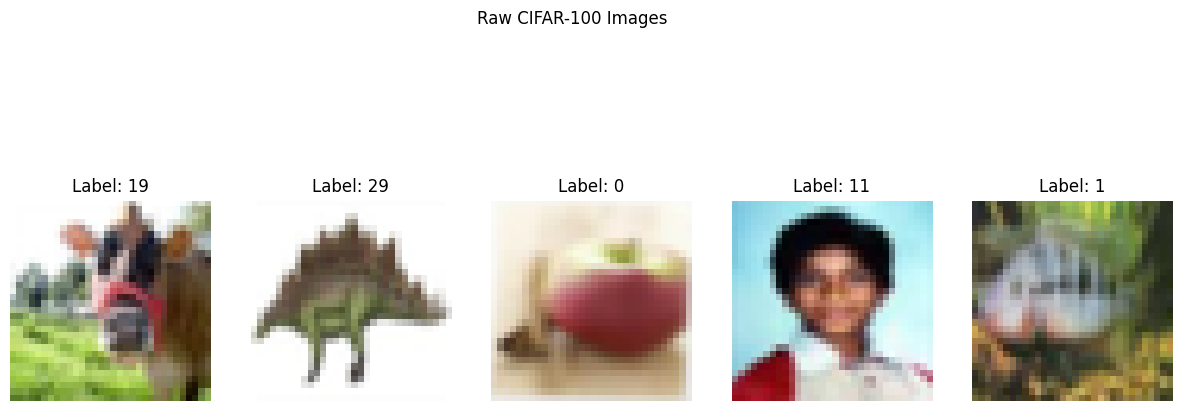

In [ ]:
# Combine datasets if needed or use either one for visualization
full_dataset = raw_train_dataset  # or use raw_test_dataset, depending on what you want to visualize

# Visualize raw CIFAR-100 data
def visualize_data(dataset, num_images=5, title=""):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        # Convert the PIL image to a NumPy array
        image = np.array(dataset[i][0])  # Get the image as a NumPy array
        plt.imshow(image)  # Directly use the NumPy array for display
        plt.title(f'Label: {dataset[i][1]}')  # Assuming the second element is the label
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display raw images
visualize_data(full_dataset, num_images=5, title="Raw CIFAR-100 Images")

In [ ]:
# Load CIFAR-100 datasets with augmentations for training and testing
augmented_dataset = CIFAR100(root='/path/with/permissions/', train=True, download=True, transform=transform)

Files already downloaded and verified


In [ ]:

# Split the dataset into training and testing datasets
train_size = int(0.8 * len(augmented_dataset))
test_size = len(augmented_dataset) - train_size
train_dataset, test_dataset = random_split(augmented_dataset, [train_size, test_size])

In [ ]:
# Create DataLoaders for training and testing with multiple workers
num_workers = 4  # Adjust based on the number of CPU cores available
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=num_workers)  # Increased batch size for more stable gradients  # Reduced batch size to introduce gradient noise for better generalization  # Increased batch size to smoothen gradients
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=num_workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Image 0 shape before transpose: (3, 224, 224)
Image 0 shape after transpose: (224, 224, 3)
Image 1 shape before transpose: (3, 224, 224)
Image 1 shape after transpose: (224, 224, 3)
Image 2 shape before transpose: (3, 224, 224)
Image 2 shape after transpose: (224, 224, 3)
Image 3 shape before transpose: (3, 224, 224)
Image 3 shape after transpose: (224, 224, 3)
Image 4 shape before transpose: (3, 224, 224)
Image 4 shape after transpose: (224, 224, 3)


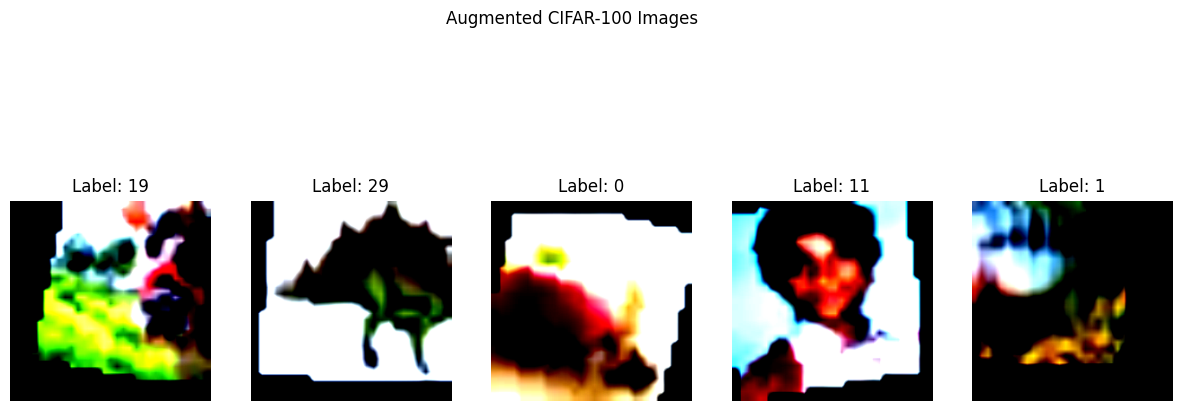

In [ ]:
# Visualize raw and augmented CIFAR-100 data
def visualize_data(dataset, num_images=5, title=""):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        # Convert the image to a NumPy array
        image = np.array(dataset[i][0])  # Get the image as a NumPy array

        # Print the shape for debugging
        print(f"Image {i} shape before transpose: {image.shape}")

        # If the image is in CHW format, convert it to HWC format
        if image.ndim == 3 and image.shape[0] == 3:  # Check for CHW format
            image = image.transpose((1, 2, 0))  # Convert to HWC format

        # Print the shape after transpose for debugging
        print(f"Image {i} shape after transpose: {image.shape}")

        plt.imshow(image)  # Directly use the NumPy array for display
        plt.title(f'Label: {dataset[i][1]}')  # Assuming the second element is the label
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize augmented data
visualize_data(augmented_dataset, num_images=5, title="Augmented CIFAR-100 Images")

Starting epoch 1/20...
[Epoch 1, Batch 10] loss: 6.209
[Epoch 1, Batch 20] loss: 5.899
[Epoch 1, Batch 30] loss: 6.120
[Epoch 1, Batch 40] loss: 6.040
[Epoch 1, Batch 50] loss: 5.907
[Epoch 1, Batch 60] loss: 6.011
[Epoch 1, Batch 70] loss: 5.913
[Epoch 1, Batch 80] loss: 5.843
[Epoch 1, Batch 90] loss: 5.796
[Epoch 1, Batch 100] loss: 6.019
[Epoch 1, Batch 110] loss: 5.935
[Epoch 1, Batch 120] loss: 5.949
[Epoch 1, Batch 130] loss: 5.869
[Epoch 1, Batch 140] loss: 6.146
[Epoch 1, Batch 150] loss: 5.875
[Epoch 1, Batch 160] loss: 5.852
[Epoch 1, Batch 170] loss: 6.035
[Epoch 1, Batch 180] loss: 5.842
[Epoch 1, Batch 190] loss: 5.894
[Epoch 1, Batch 200] loss: 6.020
[Epoch 1, Batch 210] loss: 5.958
[Epoch 1, Batch 220] loss: 5.763
[Epoch 1, Batch 230] loss: 6.009
[Epoch 1, Batch 240] loss: 5.795
[Epoch 1, Batch 250] loss: 5.873
[Epoch 1, Batch 260] loss: 5.848
[Epoch 1, Batch 270] loss: 5.685
[Epoch 1, Batch 280] loss: 5.702
[Epoch 1, Batch 290] loss: 5.933
[Epoch 1, Batch 300] loss: 5.

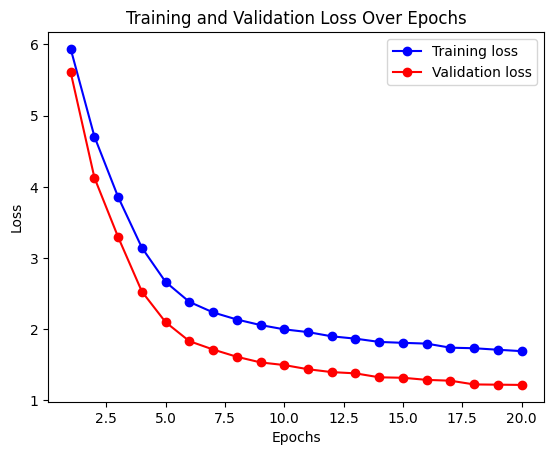

In [ ]:
# Loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
# Define accumulation steps
accumulation_steps = 4

# Placeholder for hyperparameter tuning using random search
def random_search_hyperparameters():
    pass

random_search_hyperparameters()
num_epochs = 20

# Gradient Scaler for mixed precision training
scaler = torch.amp.GradScaler()

# Learning rate scheduler and warm-up
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def lr_lambda(x):
        if x < warmup_iters:
            return warmup_factor * (1 + x) / warmup_iters
        return 1
    return LambdaLR(optimizer, lr_lambda)

warmup_scheduler = warmup_lr_scheduler(optimizer, warmup_iters=3000, warmup_factor=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6, verbose=True)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=5)

# Training loop with extended batches per epoch and additional improvements
train_losses = []
val_losses = []
batches_per_epoch = len(train_loader) // 2

# Reduced dropout rate to retain more information during training
dropout = nn.Dropout(p=0.2)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    print(f"Starting epoch {epoch + 1}/{num_epochs}...")

    for i, (images, labels) in enumerate(train_loader):
        if i >= batches_per_epoch:
            break

        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Mixed precision training
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images).logits
            if model.training:
                outputs = dropout(outputs)
            loss = criterion(outputs, labels)

        # Backward pass with mixed precision
        scaler.scale(loss).backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        # Optimizer step using scaler
        scaler.step(optimizer)
        scaler.update()

        # Accumulate loss
        running_loss += loss.item()
        epoch_loss += loss.item()

        if i % 10 == 9:
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 10:.3f}")
            running_loss = 0.0

    # Adjust learning rate using the scheduler
    scheduler.step(epoch_loss / batches_per_epoch)

    # Save the average loss for each epoch
    train_losses.append(epoch_loss / batches_per_epoch)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

print("Finished Training")

# Additional suggestion: Plot training and validation accuracy to monitor overfitting
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test Accuracy: 66.86%


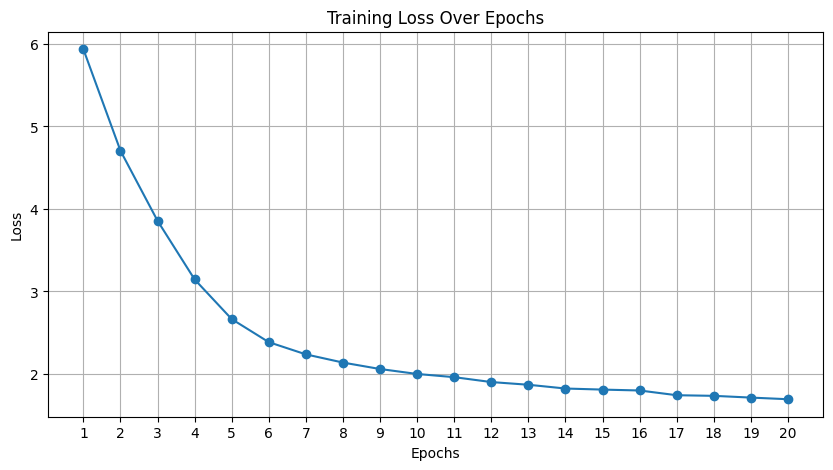

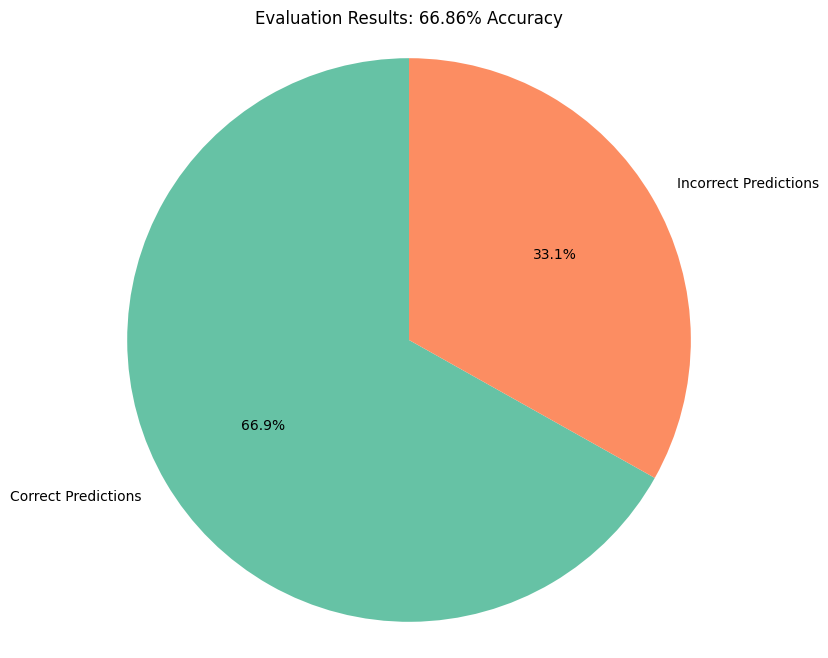

In [ ]:
# Evaluation loop
model.eval()  # Set model to evaluation mode
total = 0
correct = 0

with torch.no_grad():  # Disable gradient calculation for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

# Visualize training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))
plt.grid()
plt.show()

# Visualize evaluation results
labels = ['Correct Predictions', 'Incorrect Predictions']
sizes = [correct, total - correct]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
plt.title(f'Evaluation Results: {accuracy:.2f}% Accuracy')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.
plt.show()